In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import numpy as np
from scipy.optimize import minimize
np.random.seed(42)

In [2]:
#n_wires = 8
stepsize=0.5
#graph = [(0, 1, 1), (0, 3, 1), (0,6,1), (1, 2,1), (2, 3,1), (2,7,1), (3,5,1),(1,5,1),(2,4,1),(4,5,1),(4,5,1),(5,6,1),(5,7,1),(6,7,1)]
n_wires = 5
graph = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]


# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

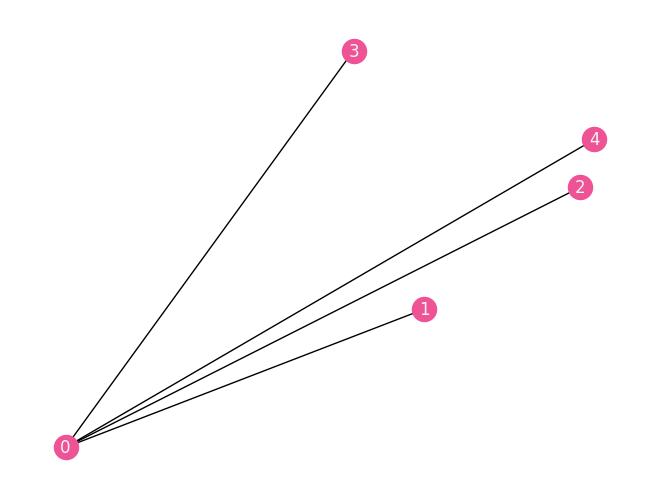

In [3]:
# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

G = rx.PyGraph()
G.add_nodes_from(range(n_wires))
G.add_edges_from(graph)
mpl_draw(
    G, pos=rx.random_layout(G, None, 4), with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

In [4]:
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

In [5]:
dev = qml.device("lightning.qubit", wires=n_wires, shots=1)

In [6]:
@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample()
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)


p=1
[[0.00183435]
 [0.00779691]]
Objective after step     5:  3.0000000
Objective after step    10:  2.0000000
Optimized (gamma, beta) vectors:
[[ 0.75548506]
 [-0.3725569 ]]
Most frequently sampled bit string is: 10000


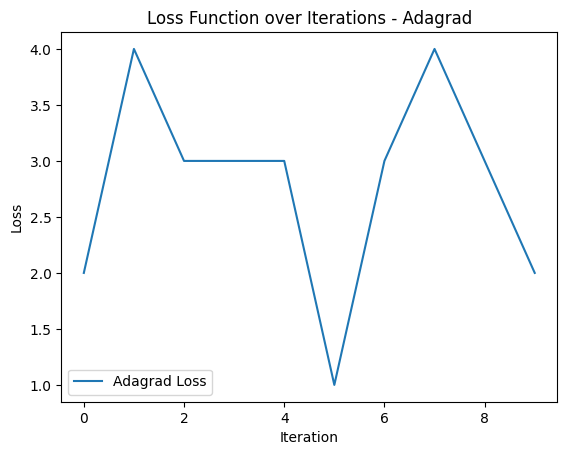


p=3
[[0.0059685  0.00445833 0.00099975]
 [0.00459249 0.00333709 0.00142867]]
Objective after step     5:  2.0000000
Objective after step    10:  3.0000000
Optimized (gamma, beta) vectors:
[[ 0.24655046 -0.4215348  -0.27926776]
 [-0.02180763 -0.23117273  0.29825969]]
Most frequently sampled bit string is: 01111


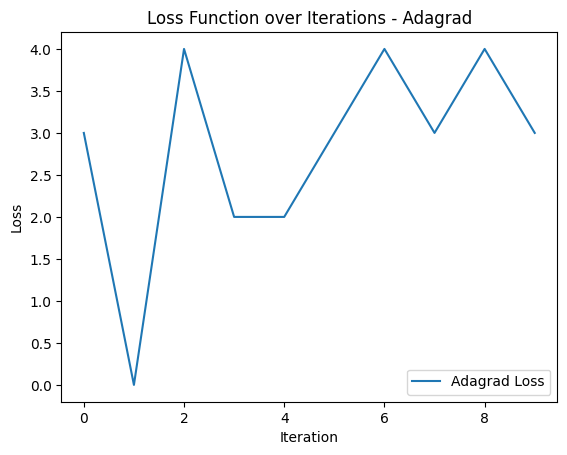

In [7]:
def qaoa_maxcut(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)
    print(init_params)
    loss_values = []

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 10
    for i in range(steps):
        params = opt.step(objective, params)
        loss = -objective(params)
        loss_values.append(loss)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, loss))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:05b}".format(most_freq_bit_string))
    
    plt.plot(loss_values, label=f"Adagrad Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Loss Function over Iterations - Adagrad")
    plt.legend()
    plt.show()
    
    return -objective(params), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
bitstrings1 = qaoa_maxcut(n_layers=1)[1]
bitstrings2 = qaoa_maxcut(n_layers=3)[1]


p=1
[[0.00650888]
 [0.00056412]]
Current gammas: [0.00650888], betas: [0.00056412]
Objective value: -1.0
Current gammas: [0.00650889], betas: [0.00056412]
Objective value: -4.0
Current gammas: [0.00650888], betas: [0.00056413]
Objective value: -3.0
Current gammas: [0.0065089], betas: [0.00056412]
Objective value: -2.0
Current gammas: [0.00650891], betas: [0.00056412]
Objective value: -3.0
Current gammas: [0.0065089], betas: [0.00056413]
Objective value: -3.0
Current gammas: [0.00650889], betas: [0.00056412]
Objective value: -2.0
Current gammas: [0.0065089], betas: [0.00056412]
Objective value: -2.0
Current gammas: [0.00650889], betas: [0.00056413]
Objective value: -2.0
Current gammas: [0.00650889], betas: [0.00056412]
Objective value: -2.0
Current Objective : 2.0000000


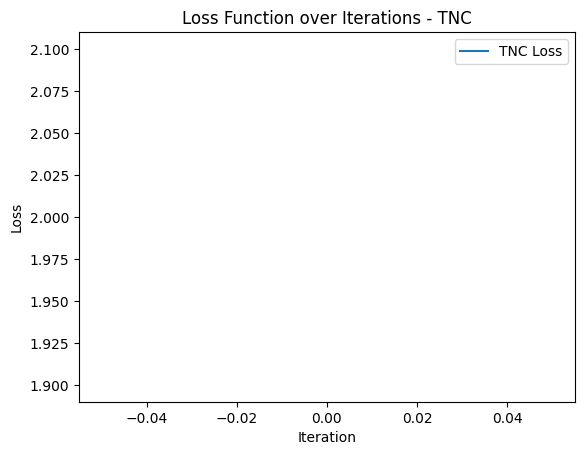

Optimized (gamma, beta) vectors:
[[0.00650889]
 [0.00056412]]
Most frequently sampled bit string is: 00001
Current gammas: [0.00650889], betas: [0.00056412]
Objective value: -1.0

p=3
[[7.21998772e-03 9.38552709e-03 7.78765841e-06]
 [9.92211559e-03 6.17481510e-03 6.11653160e-03]]
Current gammas: [7.21998772e-03 9.38552709e-03 7.78765841e-06], betas: [0.00992212 0.00617482 0.00611653]
Objective value: -2.0
Current gammas: [7.21999772e-03 9.38552709e-03 7.78765841e-06], betas: [0.00992212 0.00617482 0.00611653]
Objective value: -1.0
Current gammas: [7.21998772e-03 9.38553709e-03 7.78765841e-06], betas: [0.00992212 0.00617482 0.00611653]
Objective value: -3.0
Current gammas: [7.21998772e-03 9.38552709e-03 7.79765841e-06], betas: [0.00992212 0.00617482 0.00611653]
Objective value: -4.0
Current gammas: [7.21998772e-03 9.38552709e-03 7.78765841e-06], betas: [0.00992213 0.00617482 0.00611653]
Objective value: -2.0
Current gammas: [7.21998772e-03 9.38552709e-03 7.78765841e-06], betas: [0.00992

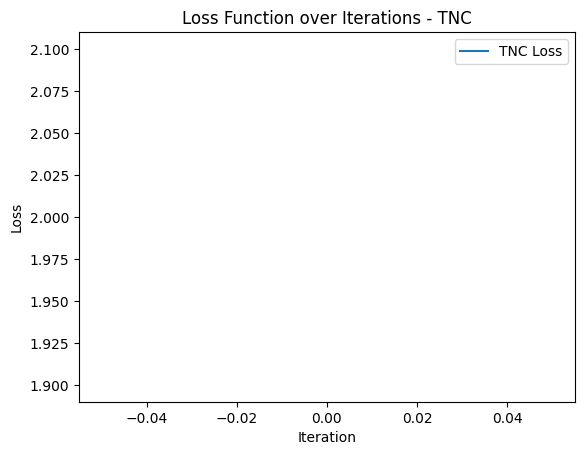

Optimized (gamma, beta) vectors:
[[7.21998714e-03 9.38552768e-03 7.78881680e-06]
 [9.92211559e-03 6.17481568e-03 6.11653160e-03]]
Most frequently sampled bit string is: 01111
Current gammas: [7.21998714e-03 9.38552768e-03 7.78881680e-06], betas: [0.00992212 0.00617482 0.00611653]
Objective value: -3.0


In [8]:
def qaoa_maxcut(n_layers=1):
    method = "TNC"
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers)
    print(init_params)
    loss_values = []

    # minimize the negative of the objective function
    def objective(x):
        gammas = x[:n_layers]
        betas = x[n_layers:]
        print(f"Current gammas: {gammas}, betas: {betas}")
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
        print(f"Objective value: {neg_obj}")
        return neg_obj

    # optimize parameters in objective
    x0 = init_params
    steps = 30

    def callback(x):
        # Compute the loss function value at each step
        loss_value = -objective(x)
        print("Current Objective :{: .7f}".format(loss_value))
        loss_values.append(loss_value)
        
    res = minimize(objective, x0.flatten(), callback=callback, method=method)

    # Plot the loss values for this method
    plt.plot(loss_values, label=f"{method} Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Loss Function over Iterations - {method}")
    plt.legend()
    plt.show()

    params_final = res.x.reshape(2, n_layers)

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit(params_final[0], params_final[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params_final[:, :n_layers]))
    print("Most frequently sampled bit string is: {:05b}".format(most_freq_bit_string))
    
    
    return -objective(params_final.flatten()), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
bitstrings1 = qaoa_maxcut(n_layers=1)[1]
bitstrings2 = qaoa_maxcut(n_layers=3)[1]